### Chapter2. 머신러닝 프로젝트 처음부터 끝까지 ###  
<캘리포니아 주택 가격 예측을 중심으로>

*회귀의 성능 측정 
1. RMSE(평균 제곱근 오차)  
$ RMSE(X,h) = \sqrt{\frac{1}{m}\sum_{i=1}^m(h(x^{(i)})-y^{(i)})^2)} $

2. MAE(평균 절대 오차)  
$ MAE(X,h) = \frac{1}{m}\sum_{i=1}^m|h(x^{(i)})-y^{(i)}| $

In [18]:
#환경 설정
import sys 
assert sys.version_info >= (3,5) #assert; 원하는 조건의 변수 값을 보증받기 위한 함수

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

#(그래프 등의) 저장 위치 설정
project_root_dir = "C:\\Users\\eunju\\Desktop\\GitHub\\Machine-Learning"
chapter_id = "end_to_end_project"
images_path = os.path.join(project_root_dir, "images", chapter_id) #경로를 병합하여 새 경로 생성
                                                                   #.\images\end_to_end_project
os.makedirs(images_path, exist_ok=True) #원하는 만큼 디렉토리 생성

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(images_path, fig_id +"." +fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path,format=fig_extension, dpi=resolution)


#불필요한 경고 무시
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


### 1. 데이터 가져오기 ###

In [19]:
import os
import tarfile
import urllib

download_root = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = download_root + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path): #디렉토리 없다면
        os.makedirs(housing_path) #디렉토리를 만들어라
    tgz_path = os.path.join(housing_path, "housiing.tgz") #경로 생성
    urllib.request.urlretrieve(housing_url, tgz_path) #경로에 파일 저장
    housing_tgz = tarfile.open(tgz_path) #압축파일 열기
    housing_tgz.extractall(path=housing_path) #압축해제(경로)
    housing_tgz.close()
    
#urlib.request; url주소의 문서를 열고 읽기 위해 사용하는 모듈
#urlretrieve; 로컬 파일로 저장 (직접 다운로드)
#urlopen; 메모리로 로드

In [20]:
fetch_housing_data()

In [21]:
import pandas as pd 
#numpy 또한, csv파일을 편리하게 핸들링하기 좋다

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [22]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [23]:
housing.info() #데이터의 특성을 보여줌
               #total_bedroons 누락된 값 고려할 필요 있다.
               #ocean_proximity ; data type -> object(문자)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [24]:
#ocean_proxmity 어떤값?
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [25]:
housing.describe() #데이터의 여러 통계량을 보여줌

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


C:\Users\eunju\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eunju\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eunju\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eunju\Anaconda3\lib\site-packages\pandas\plotting\_matpl

그림 저장: attribute_histogram_plots


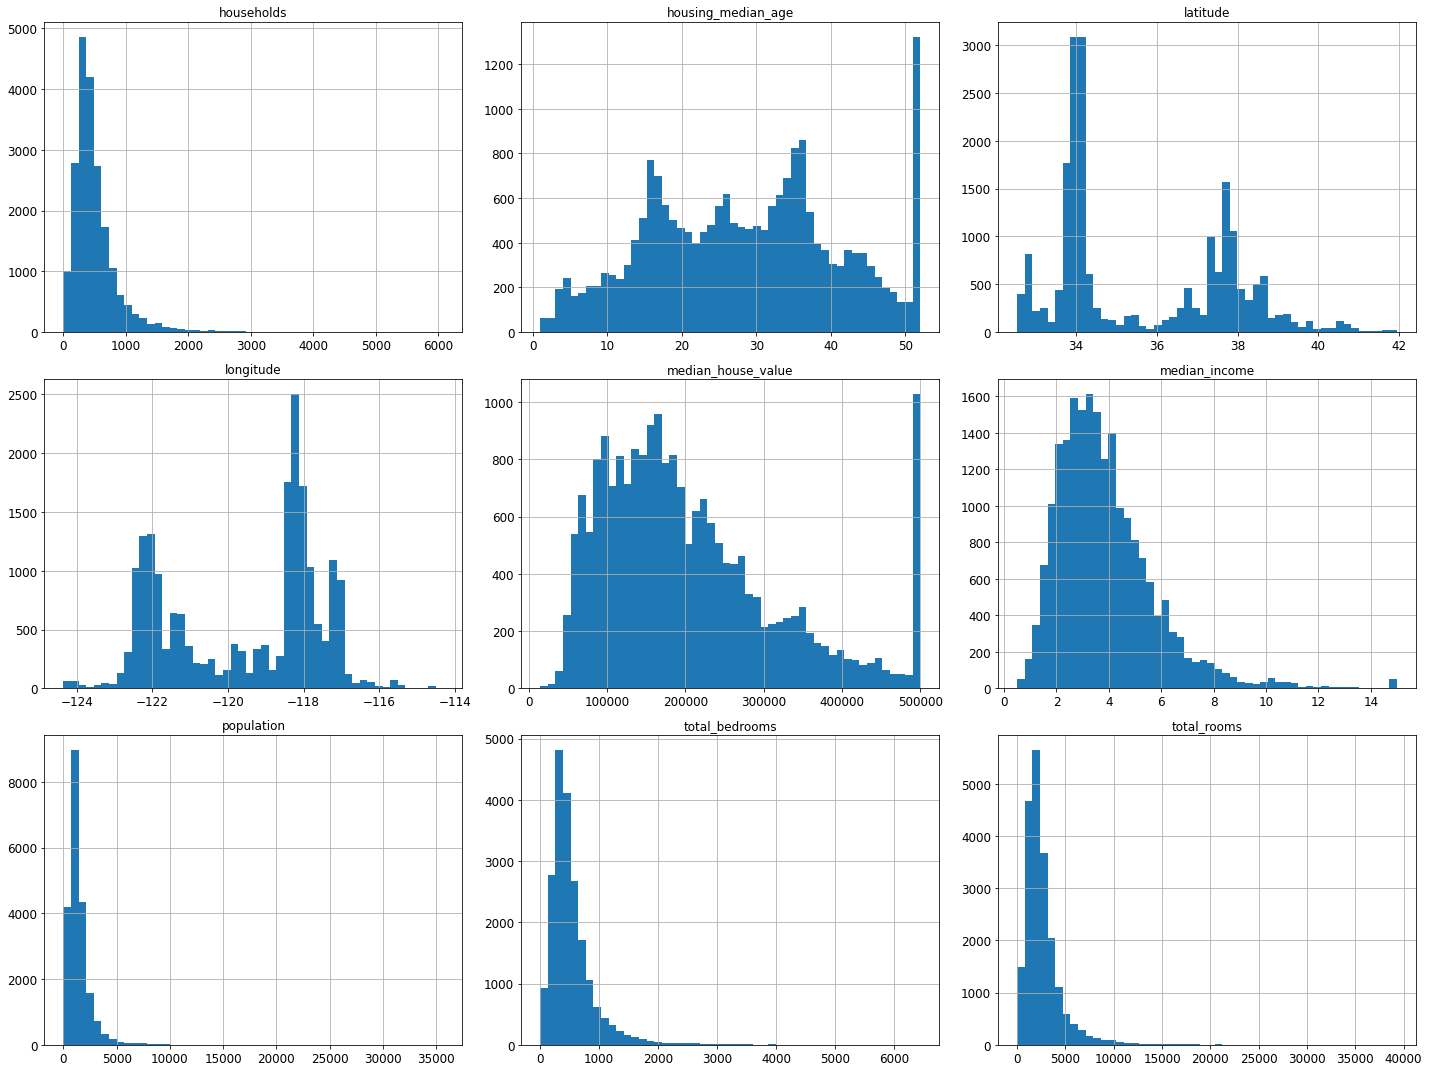

In [26]:
#히스토그램 작성
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15)) #50개의 구간으로 나눔
save_fig("attribute_histogram_plots")
plt.show()

#이상치 존재
#왼쪽으로 치우쳐진 그래프 -> 종모양에 가깝게 
#단위 다름 등의 문제 확인

In [33]:
# test set 설정
np.random.seed(42)
import numpy as np

def split_train_test(data, test_ratio): #사이킷런의 train_test_split()과 같은 역할
    shuffled_indices = np.random.permutation(len(data)) #permutation; 배열->섞어줌, 정수->정수 이하의 숫자를 섞어 배열
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
    #iloc; index를 기반으로 인덱싱(train데이터, test행)

In [37]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [38]:
len(test_set)

4128

In [40]:
#모델을 만드는 중 전체 데이터 수가 변경이 되는 경우(데이터 추가 등)
#test set이 바뀔 수 있다-> test set이 모델에 노출될 수 있으므로 이를 방지
#각 샘플마다 고유한 해시값을 계산 -> 해시 최대값의 20%이하의 샘플만 test set으로 설정

from zlib import crc32

def test_set_check(idenfifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio *2**32
            #정수->int64로 변경          #test_ratio(0.2)보다 작은 것 선택

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column] #series 객체=> apply를 이용하여 lambda함수
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set] #loc; 행의 순서대로 인덱싱

In [43]:
#위의 내용 hashlib을 이용하여서도 가능
import hashlib
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return (hash(np.int64(identifier)).digest())[-1] < 256*test_ratio

#Python3에서 불가능 ->
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [46]:
#housing data frame => index 열 추가
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"] #식별자를 만들어
train_set, test_set= split_train_test_by_id(housing_with_id, 0.2, "id") #train, test 구분할 수 있다-> 완전히 고유하지 않을 수 있다.

In [47]:
#모듈을 이용하여 train, test 구분
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [48]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


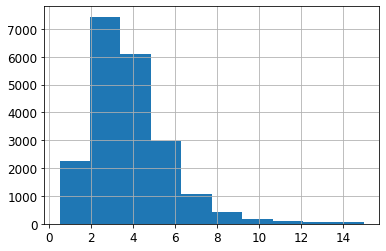

In [49]:
housing["median_income"].hist() #연속적인 데이터라 고르게 나눌 수 없다. -> 범주형 데이터로 변경

In [50]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0.,1.5,3.0,4.5,6.,np.inf], #구간을 나누어줌
                              labels=[1,2,3,4,5])
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

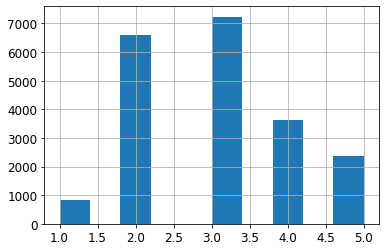

In [51]:
housing["income_cat"].hist() #편향된 그래프 종모양에 가깝게 할 수 있다.

In [53]:
# 범주형 특성 -> train,test 골고루 나누도록 함(동등한 비례로) => 사이킷런
from sklearn.model_selection import StratifiedShuffleSplit 
                                     # 계층형 분할

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


In [54]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set) 

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [55]:
housing["income_cat"].value_counts() / len(housing) #비율이 유사함을 알 수 있다.

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [56]:
# 범주형 자료를 train, test 나누기 (계층형 분할과는 다르다)
st_train_set, st_test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing["income_cat"])

In [57]:
st_train_set["income_cat"].value_counts() / len(st_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

In [59]:
#계층분할과의 차이점 확인
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall" : income_cat_proportions(housing),
    "Stratified" : income_cat_proportions(strat_test_set),
    "Random" : income_cat_proportions(test_set) #범주별 자료 고려하지 않으면 비율이 달라진다  
}).sort_index()

compare_props["Rand. %error"] = 100*compare_props["Random"] / compare_props["Overall"] -100
compare_props["strat. %error"] = 100*compare_props["Stratified"] / compare_props["Overall"] -1000

In [60]:
compare_props

,Overall,Stratified,Random,Rand. %error,strat. %error
1,0.039826,0.039729,0.040213,0.973236,-900.243309
2,0.318847,0.318798,0.324370,1.732260,-900.015195
3,0.350581,0.350533,0.358527,2.266446,-900.013820
4,0.176308,0.176357,0.167393,-5.056334,-899.972520
5,0.114438,0.114583,0.109496,-4.318374,-899.872989


In [62]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True) #범주형 자료 삭제

### 2. 데이터 이해를 위한 탐색과 시각화 ###

In [63]:
housing = strat_train_set.copy()

그림 저장: bad_visualization_plot


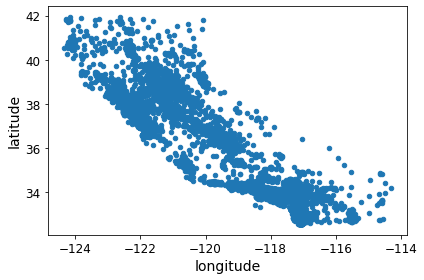

In [64]:
housing.plot(kind="scatter", x="longitude", y="latitude") #산점도
# housing.plot.scatter(x="longitude", y="latitude")
# plt.scatter(housing["longitude"], housing["latitude"])

save_fig("bad_visualization_plot") #로컬 디스크에 저장

그림 저장: better_visualization_plot


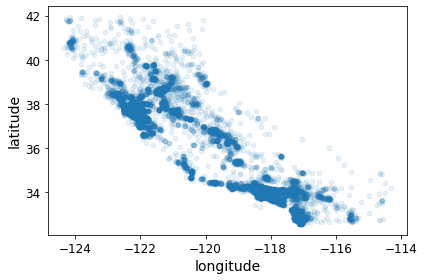

In [65]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

C:\Users\eunju\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eunju\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\eunju\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\eunju\Anaconda3\lib\site-packages\pandas\plotting\_matpl

그림 저장: housing_prices_scatterplot


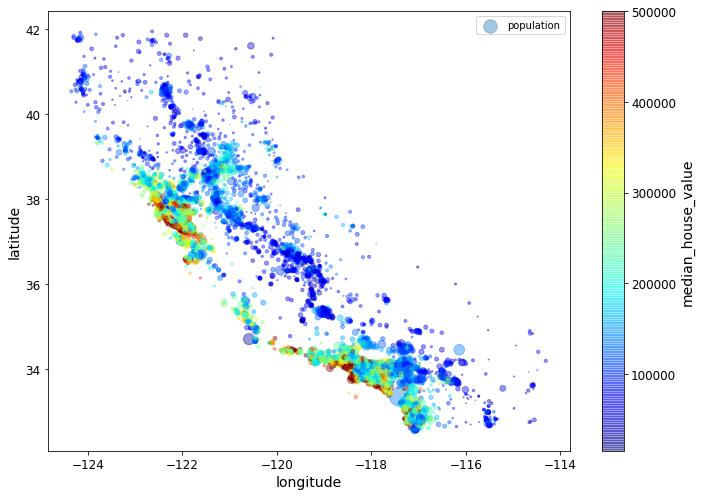

In [66]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False) #sharex=FASLE ;버그조절(x축 제대로 보여줌)
plt.legend()
save_fig("housing_prices_scatterplot")

# s; 그릴 원의 크기 -> 인구 수 많을수록 크다
# c; 원의 색깔 -> 가격이 비쌀수록 색깔이 강하게 나타난다. 
# jet color map; 값이 높을수록 빨갛게 낮을수록 파랗게

In [71]:
#Download the California image - 실제와 비교
images_path = os.path.join(project_root_dir, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('C:\\Users\\eunju\\Desktop\\GitHub\\Machine-Learning\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x21b4c3096c8>)

그림 저장: california_housing_prices_plot


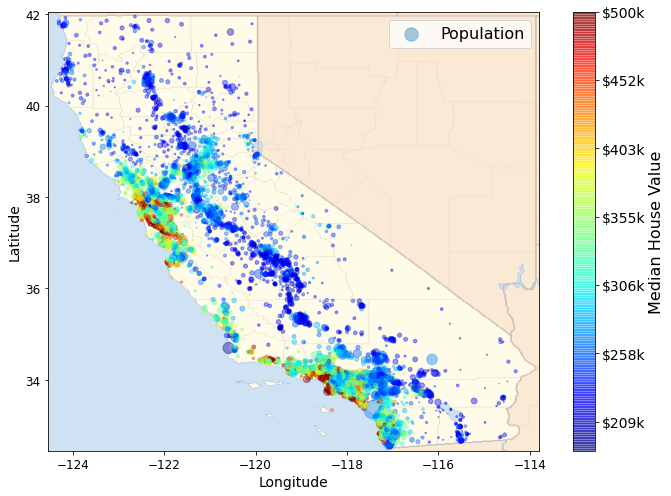

In [76]:
import matplotlib.image as mpimg
california_img = mpimg.imread(os.path.join(images_path, filename)) #imread; 이미지 읽기
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                 s=housing['population']/100, label="Population",
                 c="median_house_value", cmap=plt.get_cmap("jet"), 
                 colorbar=False, alpha=0.4)

#캘리포니아 이미지 덧붙이기
plt.imshow(california_img, extent=[-124.55,-113.80,32.45,42.05], alpha=0.5,
          cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

#컬러바 출력
prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14) #컬러바 표시=> 1000으로 나누어 구분
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()
